In [1]:
# Fix the download command and load the dataset
import os
%pip install kagglehub --quiet
import kagglehub
import pandas as pd

# Download the IMDB dataset
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")
print("Dataset downloaded to:", path)

# Find and load the CSV file
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
if csv_files:
    dataset_path = os.path.join(path, csv_files[0])
    df = pd.read_csv(dataset_path)
    print(f"Dataset loaded with {len(df)} rows and {len(df.columns)} columns")
    print("Sample data:")
    print(df.head(3))
else:
    print("No CSV file found in the downloaded dataset")

Note: you may need to restart the kernel to use updated packages.
Dataset downloaded to: /kaggle/input/
Dataset loaded with 50000 rows and 2 columns
Sample data:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive


In [2]:
# Fix numpy and matplotlib installation issues
%pip install --upgrade pip --quiet
%pip install --upgrade numpy matplotlib seaborn --quiet

# IMPORTANT: Run this cell, then RESTART the kernel before proceeding!
print("✅ Packages installed. Please restart the kernel now and then run the next cell.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.3.2 which is incompatible.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.15.3 which is incompatible.
mkl-umath 0.1.1 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.3.2 which is incompatible.
mkl-random 1.2.4 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.3.2 which is incompatible.
mkl-fft 1.3.8 requires numpy<1.27.0,>=1.26.4, but you have numpy 2.3.2 which is incompatible.
cupy-cuda12x 13.4.1 requires numpy<2.3,>=1.22, but you have numpy 2.3.2 which is incompatible.
numba 0.60.0 requires 

Note: you may need to restart the kernel to use updated packages.
NumPy version: 1.26.4
Matplotlib version: 3.7.2
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

Sentiment Distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


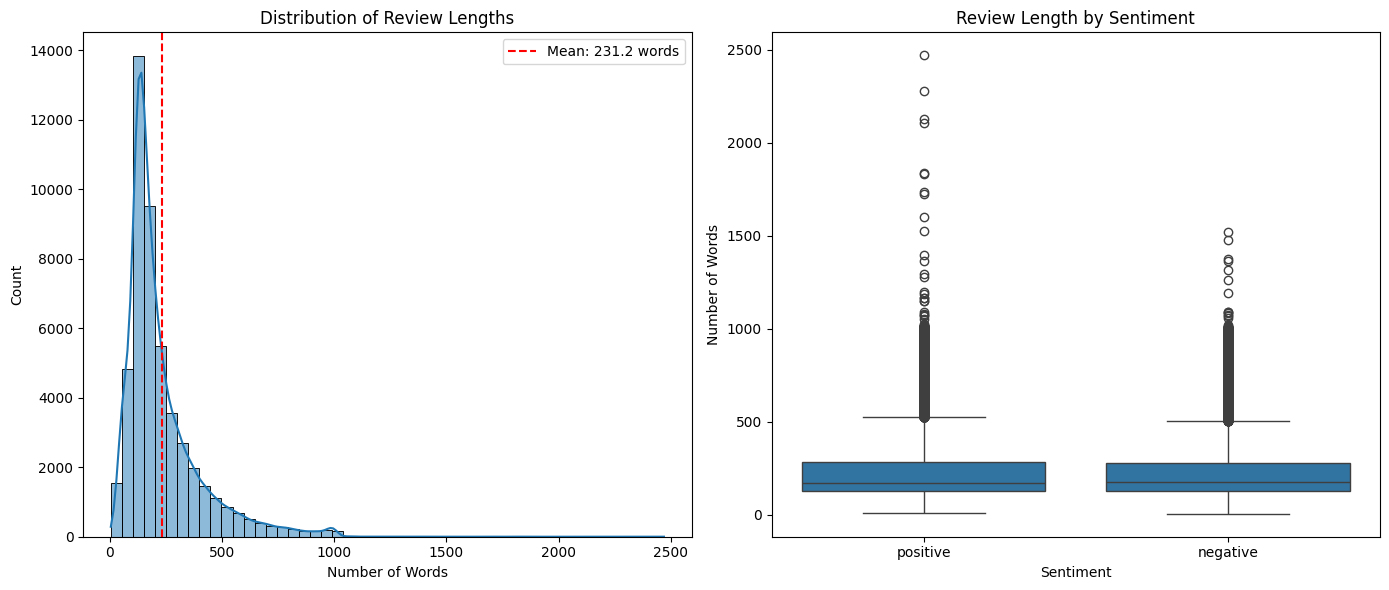


Review Length Statistics:
             count       mean         std   min    25%    50%    75%     max
sentiment                                                                   
negative   25000.0  229.46456  164.947795   4.0  128.0  174.0  278.0  1522.0
positive   25000.0  232.84932  177.497046  10.0  125.0  172.0  284.0  2470.0


In [3]:
# Fix numpy binary incompatibility
%pip install --upgrade numpy --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Verify installations
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {mpl.__version__}")

# Basic dataset information
print(df.head())
print("\nSentiment Distribution:")
print(df['sentiment'].value_counts())

# Calculate review length by word count
df['review_length'] = df['review'].apply(lambda x: len(x.split()))

# Set figure size for better visualization
plt.figure(figsize=(14, 6))

# Plot 1: Review length distribution
plt.subplot(1, 2, 1)
sns.histplot(df['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.axvline(df['review_length'].mean(), color='red', linestyle='--', 
           label=f'Mean: {df["review_length"].mean():.1f} words')
plt.legend()

# Plot 2: Compare review lengths between sentiments
plt.subplot(1, 2, 2)
sns.boxplot(x='sentiment', y='review_length', data=df)
plt.title('Review Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Number of Words')

plt.tight_layout()
plt.show()

# Print statistics
print("\nReview Length Statistics:")
print(df.groupby('sentiment')['review_length'].describe())

In [4]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r"<.*?>", " ", text)                # Remove HTML tags
    text = re.sub(r"[^a-zA-Z]", " ", text)            # Remove non-alphabet
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    return tokens

df['clean_tokens'] = df['review'].apply(clean_text)



[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
import gensim.downloader as api
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Load pretrained model
w2v_model = api.load("word2vec-google-news-300")

# Average word vector for each review
def get_avg_vector(tokens, model, dim=300):
    vectors = [model[word] for word in tokens if word in model]
    if vectors:
        return sum(vectors) / len(vectors)
    else:
        return [0.0] * dim

X = df['clean_tokens'].apply(lambda x: get_avg_vector(x, w2v_model))
X = list(X)
y = df['sentiment'].map({'positive': 1, 'negative': 0})

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy (Pretrained W2V):", accuracy_score(y_test, y_pred))


[==================================================] 100.0% 1662.8/1662.8MB downloaded
Accuracy (Pretrained W2V): 0.8199


In [6]:
#Custom Skip-Gram Word2Vec
from gensim.models import Word2Vec

# Skip-Gram: sg=1
skipgram_model = Word2Vec(sentences=df['clean_tokens'], vector_size=100, window=5, min_count=2, sg=1)

X_skip = df['clean_tokens'].apply(lambda x: get_avg_vector(x, skipgram_model.wv, dim=100))
X_train, X_test, y_train, y_test = train_test_split(list(X_skip), y, test_size=0.2)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
print("Accuracy (Skip-gram):", accuracy_score(y_test, clf.predict(X_test)))


Accuracy (Skip-gram): 0.857


In [7]:
#Custom CBOW Word2Vec
# CBOW: sg=0
cbow_model = Word2Vec(sentences=df['clean_tokens'], vector_size=100, window=5, min_count=2, sg=0)

X_cbow = df['clean_tokens'].apply(lambda x: get_avg_vector(x, cbow_model.wv, dim=100))
X_train, X_test, y_train, y_test = train_test_split(list(X_cbow), y, test_size=0.2)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
print("Accuracy (CBOW):", accuracy_score(y_test, clf.predict(X_test)))


Accuracy (CBOW): 0.8381


In [8]:
#Custom FastText Model
from gensim.models import FastText

fasttext_model = FastText(sentences=df['clean_tokens'], vector_size=100, window=5, min_count=2)

X_ft = df['clean_tokens'].apply(lambda x: get_avg_vector(x, fasttext_model.wv, dim=100))
X_train, X_test, y_train, y_test = train_test_split(list(X_ft), y, test_size=0.2)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
print("Accuracy (FastText):", accuracy_score(y_test, clf.predict(X_test)))



Accuracy (FastText): 0.8297



Classification Report:
              precision    recall  f1-score   support

    negative       0.83      0.82      0.83      4966
    positive       0.83      0.84      0.83      5034

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



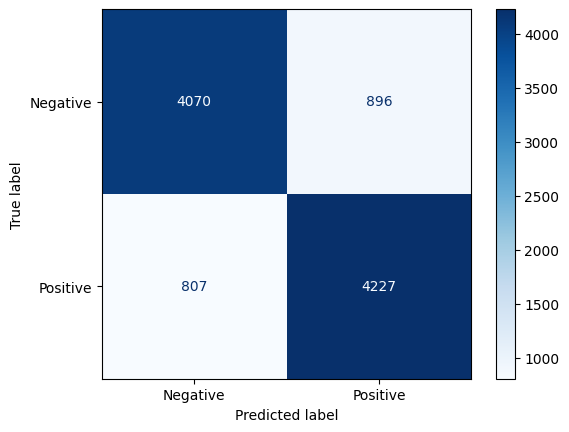

In [9]:
# Use the best model (replace with whichever had highest accuracy, e.g., FastText)
best_model = clf  # From FastText or any other section

# Predict on test set
y_pred = best_model.predict(X_test)

# Create a DataFrame to analyze predictions
test_df = pd.DataFrame({
    'review': df.iloc[y_test.index]['review'].values,
    'true_sentiment': y_test.values,
    'predicted_sentiment': y_pred
})

# Map 0/1 back to label
label_map = {1: 'positive', 0: 'negative'}
test_df['true_label'] = test_df['true_sentiment'].map(label_map)
test_df['predicted_label'] = test_df['predicted_sentiment'].map(label_map)

test_df.head()

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['negative', 'positive']))

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues')


In [10]:
# False Positives and False Negatives
false_positives = test_df[(test_df['true_label'] == 'negative') & (test_df['predicted_label'] == 'positive')]
false_negatives = test_df[(test_df['true_label'] == 'positive') & (test_df['predicted_label'] == 'negative')]

print(f"False Positives: {len(false_positives)}")
print(f"False Negatives: {len(false_negatives)}")

print("\n🔸 Sample False Positives:")
for i in range(3):
    print(f"\nReview:\n{false_positives.iloc[i]['review'][:500]}...\nTrue: Negative, Predicted: Positive")

print("\n🔸 Sample False Negatives:")
for i in range(3):
    print(f"\nReview:\n{false_negatives.iloc[i]['review'][:500]}...\nTrue: Positive, Predicted: Negative")


False Positives: 896
False Negatives: 807

🔸 Sample False Positives:

Review:
I wasn't entirely sure what to expect from a Comedy, Drama, Fantasy, Sci-Fi genre, but, given the actors involved I thought I'd give it a spin. The tone of the film felt awkward, going through patches of each of the genres but never quite felt balanced, so eventually I gave up trying, and concentrated on the cinematography and individual performances, which I thought were good on the whole, considering each character had little depth because of the nature of the story (won't give anything away h...
True: Negative, Predicted: Positive

Review:
Star Trek V definitely earns the dubious distinction of being the weakest film in the Star Trek series. Despite the good acting efforts by the actors, it suffered from a general lack of funding from Paramount Pictures. Paramount Pictures was not enthusiastic about this film at its very onset.<br /><br />The movie begins with the Enterprise crew enjoying their extended sh

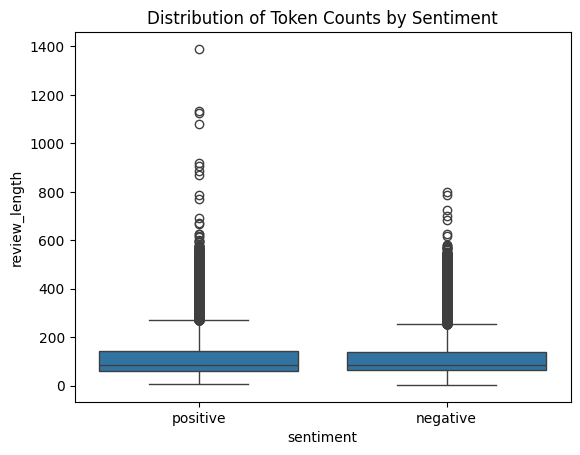

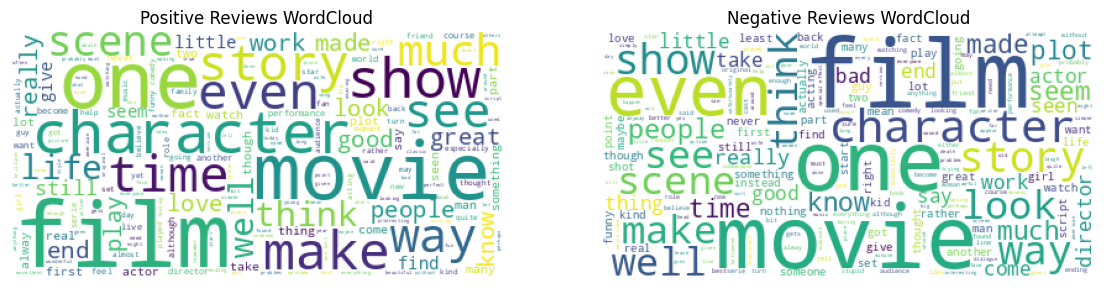

In [11]:
df['review_length'] = df['clean_tokens'].apply(len)

sns.boxplot(data=df, x='sentiment', y='review_length')
plt.title("Distribution of Token Counts by Sentiment")
plt.show()

# Word clouds (optional)
from wordcloud import WordCloud

positive_reviews = df[df['sentiment'] == 'positive']['clean_tokens'].explode().values
negative_reviews = df[df['sentiment'] == 'negative']['clean_tokens'].explode().values

positive_text = " ".join(positive_reviews)
negative_text = " ".join(negative_reviews)

# WordCloud
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.imshow(WordCloud(background_color="white").generate(positive_text))
plt.title("Positive Reviews WordCloud")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(WordCloud(background_color="white").generate(negative_text))
plt.title("Negative Reviews WordCloud")
plt.axis("off")
plt.show()